# Exploratory Data Analysis

## Load Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from io import StringIO
from scipy import stats

## Load Dataset

In [2]:
df = pd.read_csv("../Dataset/EVSE-B-PowerCombined.csv")

# Convert 'time' column to datetime for time series use
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df = df.sort_index()

print("Raw data preview:")
df.head()

Raw data preview:


,shunt_voltage,bus_voltage_V,current_mA,power_mW,State,Attack,Attack-Group,Label,interface
time,,,,,,,,,
2023-12-24 16:18:00,474,5.201,469,2420,idle,syn-stealth,recon,attack,ocpp
2023-12-24 16:18:00,609,5.185,607,3180,idle,syn-stealth,recon,attack,ocpp
2023-12-24 16:18:00,462,5.197,466,2420,idle,syn-stealth,recon,attack,ocpp
2023-12-24 16:18:00,470,5.201,465,2420,idle,syn-stealth,recon,attack,ocpp
2023-12-24 16:18:00,461,5.197,476,2500,idle,syn-stealth,recon,attack,ocpp


In [3]:
print("\nData information:")
df.info()


Data information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115298 entries, 2023-12-24 16:18:00 to 2023-12-30 16:20:00
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   shunt_voltage  115298 non-null  int64  
 1   bus_voltage_V  115298 non-null  float64
 2   current_mA     115298 non-null  int64  
 3   power_mW       115298 non-null  int64  
 4   State          115298 non-null  object 
 5   Attack         115298 non-null  object 
 6   Attack-Group   115298 non-null  object 
 7   Label          115298 non-null  object 
 8   interface      115298 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 8.8+ MB


## Initial Process

In [4]:
# Encode diagnosis as 0 (benign) / 1 (malignant)
df['Label'] = df['Label'].map({'benign': 0, 'attack': 1})
print("\Label preview after encoding:")
print(df[['Label']].head())

\Label preview after encoding:
                     Label
time                      
2023-12-24 16:18:00      1
2023-12-24 16:18:00      1
2023-12-24 16:18:00      1
2023-12-24 16:18:00      1
2023-12-24 16:18:00      1


In [5]:
# Separate feature matrix X and label y
X = df.drop(columns=['State', 'Label', 'Attack', 'Attack-Group', 'interface'])
y = df['Label']

In [6]:
# Save X and y
X.to_csv("../Dataset/X.csv")
y.to_csv("../Dataset/y.csv")

## Outlier

In [7]:
# Check for missing values and outliers
print("\nMissing value check:")
print(df.isnull().sum())


Missing value check:
shunt_voltage    0
bus_voltage_V    0
current_mA       0
power_mW         0
State            0
Attack           0
Attack-Group     0
Label            0
interface        0
dtype: int64


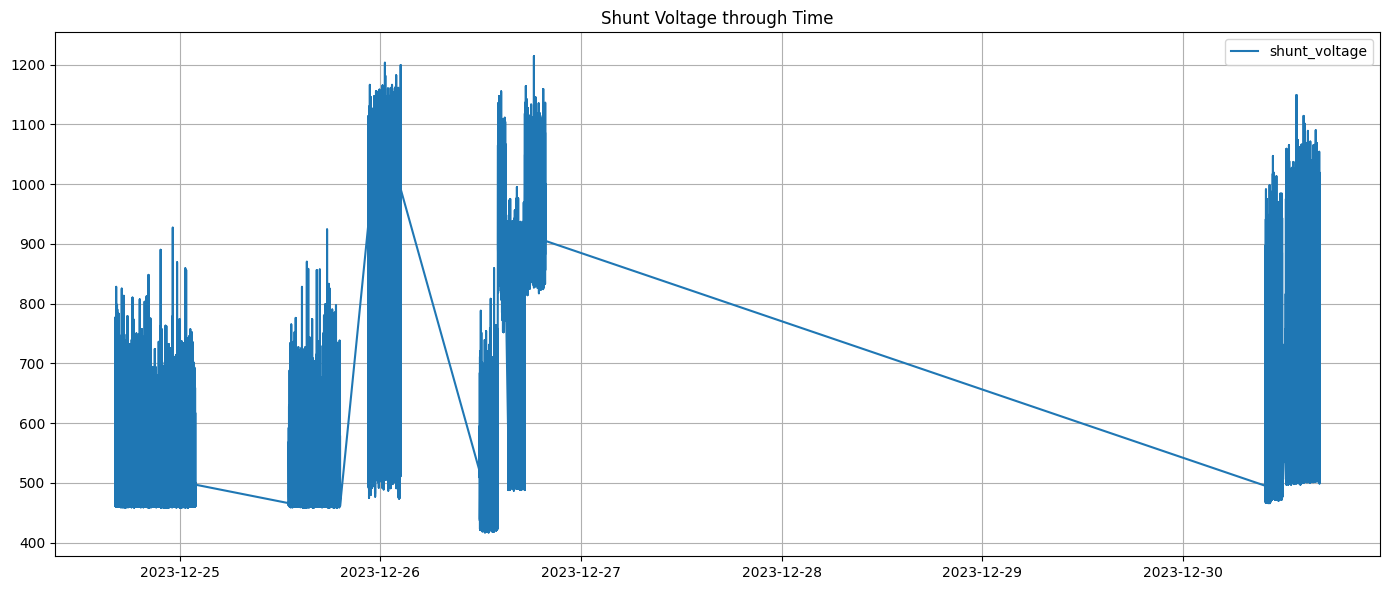

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['shunt_voltage'], label='shunt_voltage')
plt.title('Shunt Voltage through Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

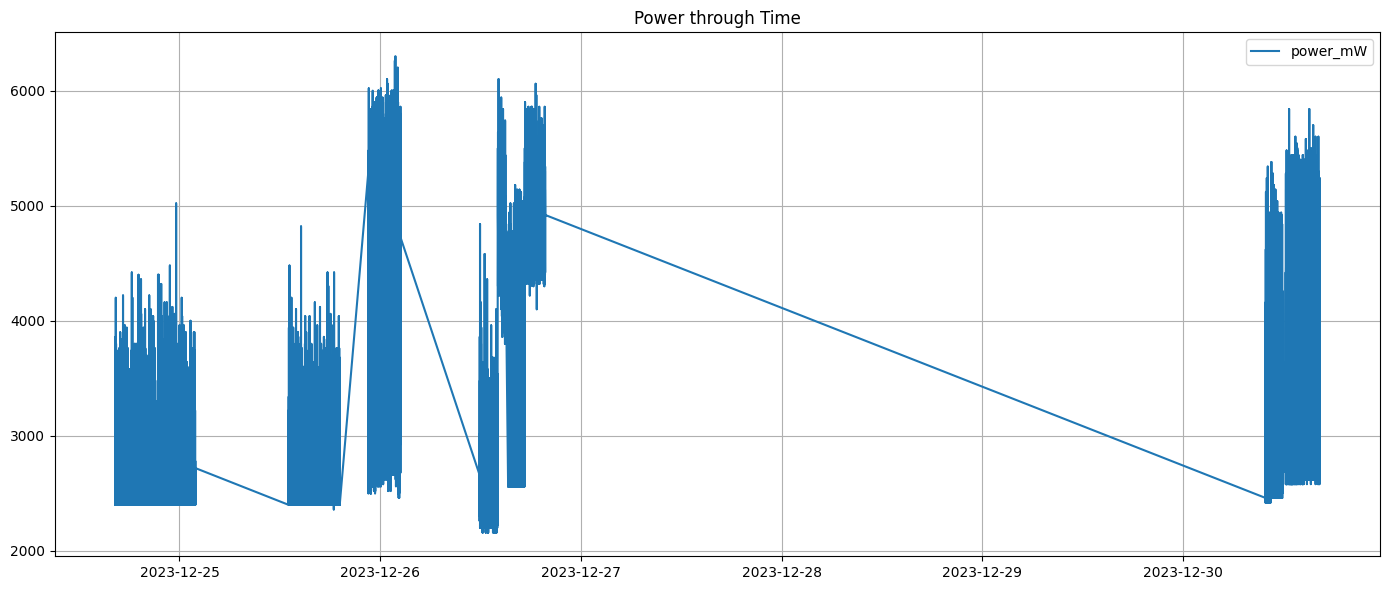

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['power_mW'], label='power_mW')
plt.title('Power through Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Descriptive statistics

In [10]:
print("Descriptive statistics of data:")
print(X.describe())

Descriptive statistics of data:
       shunt_voltage  bus_voltage_V     current_mA       power_mW
count  115298.000000  115298.000000  115298.000000  115298.000000
mean      619.787932       5.188204     619.760672    3212.783916
std       197.188339       0.014482     197.312950    1011.567259
min       417.000000       5.149000     417.000000    2160.000000
25%       467.000000       5.181000     467.000000    2420.000000
50%       510.000000       5.197000     510.000000    2660.000000
75%       746.000000       5.197000     747.000000    3860.000000
max      1214.000000       5.209000    1220.000000    6300.000000


### Z-Score (standard score)

In [11]:
z_scores = np.abs(stats.zscore(X))
threshold = 3
outliers_z = (z_scores > threshold).sum(axis=0)

print("\nNumber of outliers based on Z-Score (per column):")
print(pd.Series(outliers_z, index=X.columns))


Number of outliers based on Z-Score (per column):
shunt_voltage    1
bus_voltage_V    0
current_mA       1
power_mW         2
dtype: int64


### IQR (Interquartile Range)

In [12]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((X < lower_bound) | (X > upper_bound)).sum()

print("\nNumber of outliers based on IQR (per column):")
print(outliers_iqr)


Number of outliers based on IQR (per column):
shunt_voltage     11
bus_voltage_V    664
current_mA        12
power_mW           7
dtype: int64


### Visualize outliers

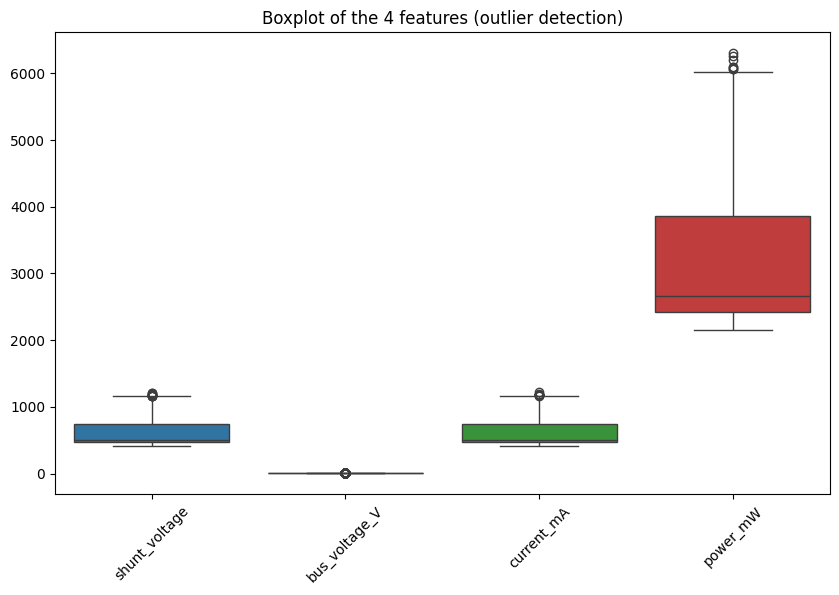

In [13]:
# Visualize outliers: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Boxplot of the 4 features (outlier detection)")
plt.xticks(rotation=45)
plt.show()

In [14]:
# If the number of outliers is small and likely noise, remove them
outlier_rows = (z_scores > threshold).any(axis=1)
n_outliers = outlier_rows.sum()
print("\nNumber of outlier samples (Z-Score > 3):", n_outliers)

# Check proportion of outliers and their association with attacks
outlier_proportion = n_outliers / len(X)
outlier_attack_proportion = y[outlier_rows].mean()
overall_attack_proportion = y.mean()

print(f"Proportion of data marked as outliers: {outlier_proportion:.2%}")
print(f"Proportion of attacks among outliers: {outlier_attack_proportion:.2%}")
print(f"Proportion of attacks in full dataset: {overall_attack_proportion:.2%}")

# Remove if <5% of data and not strongly tied to attacks
if outlier_proportion < 0.05 and outlier_attack_proportion <= overall_attack_proportion * 1.5:
    X_clean = X[~outlier_rows]
    y_clean = y[~outlier_rows]
    print("Outliers are a small fraction and not strongly attack-related, removed.")
    print("Data dimensions after removing outliers:", X_clean.shape)
else:
    X_clean = X
    y_clean = y
    print("Outliers may be significant or attack-related, retaining all data.")
    print("Data dimensions:", X_clean.shape)


Number of outlier samples (Z-Score > 3): 4
Proportion of data marked as outliers: 0.00%
Proportion of attacks among outliers: 100.00%
Proportion of attacks in full dataset: 87.54%
Outliers are a small fraction and not strongly attack-related, removed.
Data dimensions after removing outliers: (115294, 4)


In [15]:
y_clean.to_csv("../Dataset/y_clean.csv")

## Standardize all features

In [16]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns, index=X_clean.index)

print("\nPreview of standardized features:")
print(X_scaled.head())

# Check data dimensions
print("\nShape of X_scaled:", X_scaled.shape)


Preview of standardized features:
                     shunt_voltage  bus_voltage_V  current_mA  power_mW
time                                                                   
2023-12-24 16:18:00      -0.739315       0.883579   -0.764058 -0.783712
2023-12-24 16:18:00      -0.054633      -0.221316   -0.064591 -0.032325
2023-12-24 16:18:00      -0.800175       0.607355   -0.779263 -0.783712
2023-12-24 16:18:00      -0.759602       0.883579   -0.784332 -0.783712
2023-12-24 16:18:00      -0.805247       0.607355   -0.728577 -0.704618

Shape of X_scaled: (115294, 4)


In [17]:
# Save X scale data
X_scaled.to_csv("../Dataset/X_scaled.csv")

## Visualizations

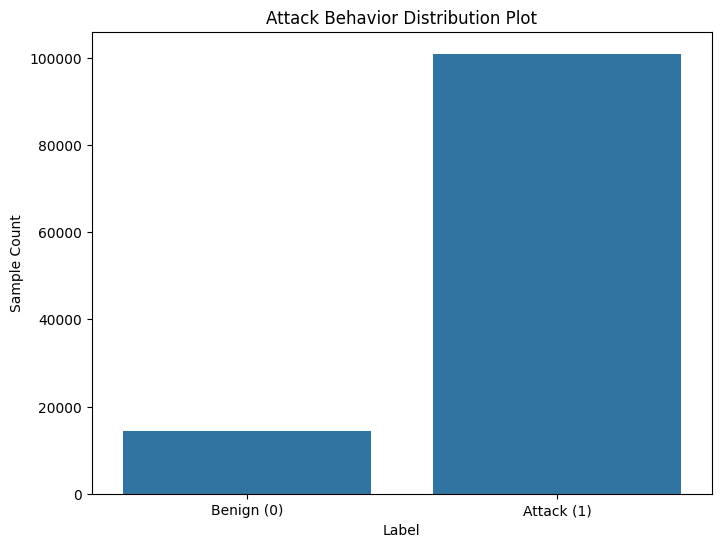

In [18]:
# Diagnosis distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(x=y_clean)
plt.title("Attack Behavior Distribution Plot")
plt.xlabel("Label")
plt.ylabel("Sample Count")
plt.xticks([0, 1], ['Benign (0)', 'Attack (1)'])
plt.show()

<Figure size 1400x800 with 0 Axes>

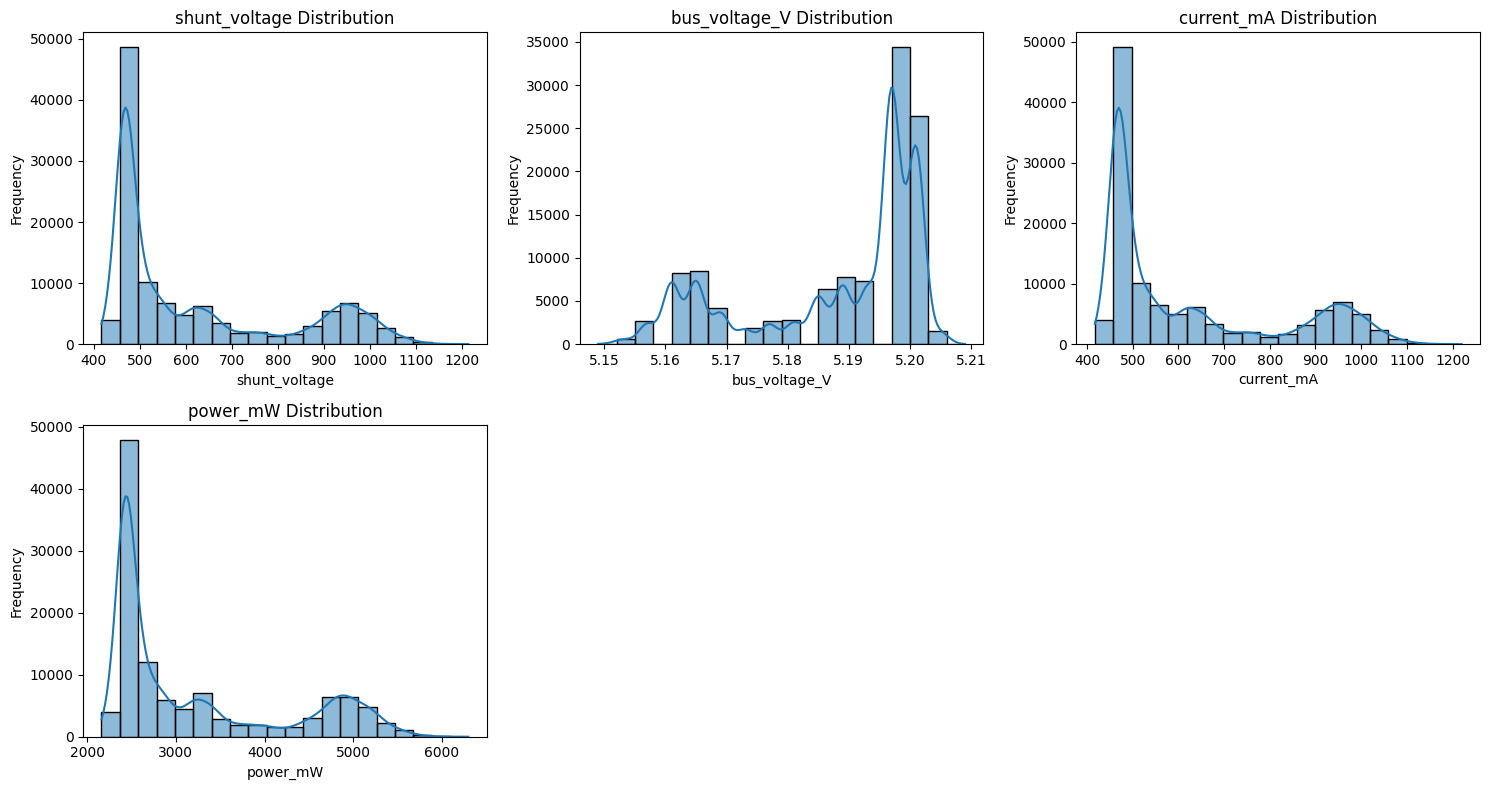

In [19]:
import math

# Feature distribution histograms
plt.figure(figsize=(14, 8))
num_features = len(X.columns)
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(X.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(X[col], bins=20, kde=True)
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

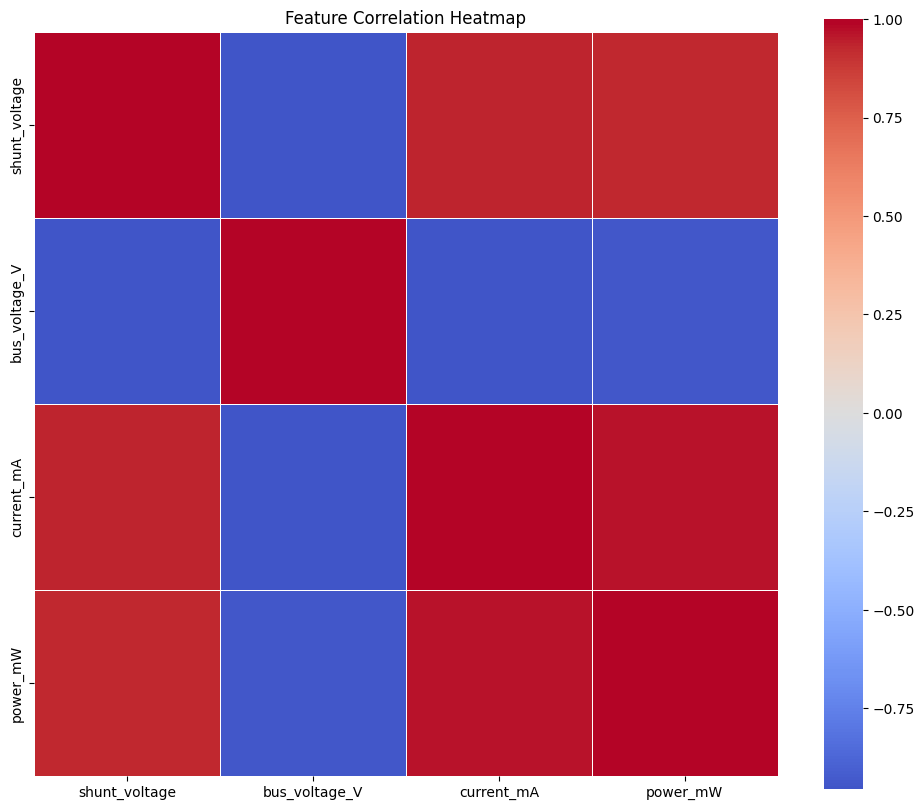

In [20]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()